## Import librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from mpl_toolkits.basemap import Basemap

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:

# create time features
def get_time_features(df):
    """
    Create time series features based on day_id series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['weekofyear'] = df.index.isocalendar().week
    
    return df



## Load the Data

In [3]:
bu_feat = pd.read_csv('data/bu_feat.csv.gz', compression='gzip')
test = pd.read_csv('data/test.csv.gz', compression='gzip')
train = pd.read_csv('data/train.csv.gz', compression='gzip')

## Data exploratory analysis

In [4]:
bu_feat.head()

,but_num_business_unit,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
0,1609,80100,50.096306,1.867220,69,4
1,1995,95700,48.991087,2.520903,3,6
2,1800,73210,45.552933,6.644736,51,4
3,238,47550,44.175370,0.638869,134,10
4,201,13546,43.508418,5.406423,71,10


In [5]:
bu_feat.zod_idr_zone_dgr.unique()

array([ 4,  6, 10,  3, 72, 35,  1, 59], dtype=int64)

In [6]:
bu_feat.shape

(326, 6)

In [7]:
train.shape

(277719, 4)

In [8]:
train.head()

,day_id,but_num_business_unit,dpt_num_department,turnover
0,2017-09-30,64,127,580.308443
1,2017-09-30,119,127,1512.995918
2,2017-09-30,4,88,668.593556
3,2017-09-30,425,127,0.000000
4,2017-09-30,513,73,0.000000


In [9]:
# number of stores in train data
len(train['but_num_business_unit'].unique())

322

- #### Merge business unit data with train data

In [10]:
train = pd.merge(bu_feat, train, on='but_num_business_unit')

In [11]:
# convert day_id to datetime and make sure that data is ordered time series order
train['day_id'] = pd.to_datetime(train['day_id'])
train.sort_values('day_id', inplace=True)
train = train.set_index('day_id')
train.index = pd.to_datetime(train.index)

# create time features
train = get_time_features(train)

In [12]:
train.tail()

,but_num_business_unit,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr,dpt_num_department,turnover,quarter,month,year,weekofyear
day_id,,,,,,,,,,,,
2017-09-30,89,76410,49.327556,1.094872,30,6,73,38.465287,3,9,2017,39
2017-09-30,89,76410,49.327556,1.094872,30,6,127,908.485411,3,9,2017,39
2017-09-30,89,76410,49.327556,1.094872,30,6,117,44.517545,3,9,2017,39
2017-09-30,724,38150,45.327709,4.804922,52,4,73,1.985217,3,9,2017,39
2017-09-30,1609,80100,50.096306,1.867220,69,4,127,358.028653,3,9,2017,39


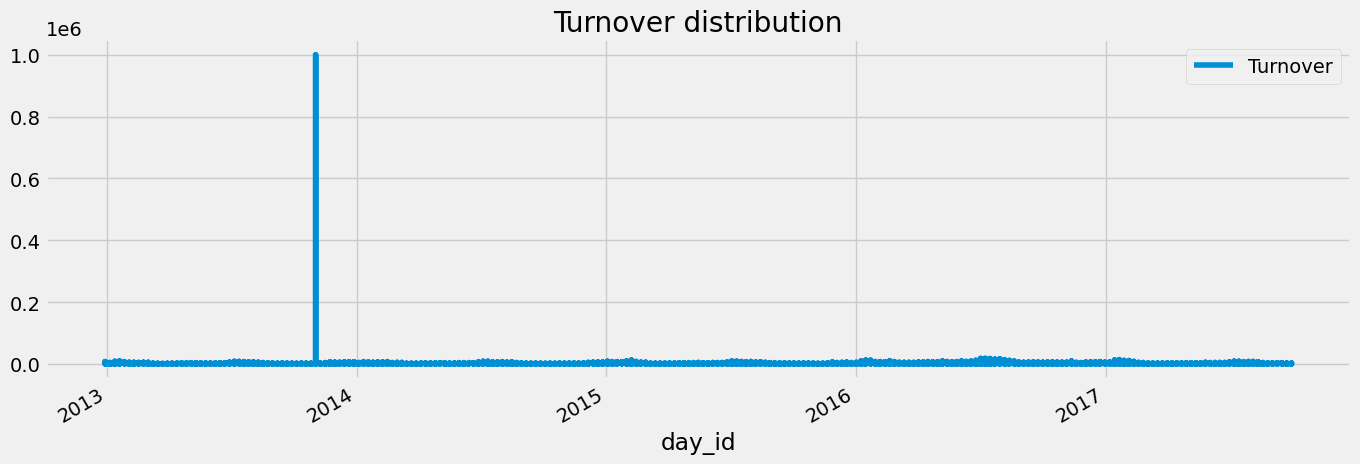

In [13]:
ax = train[['turnover']].plot(figsize=(15, 5))
plt.legend(['Turnover'])
ax.set_title('Turnover distribution')
plt.show()

From the plot above, near 2014 we have a very big pick, which may not be normal value

In [14]:
train['turnover'].describe()

count     277719.000000
mean         561.818472
std         2113.229765
min          -69.791165
25%           11.785140
50%          232.724186
75%          676.655825
max      1000000.000000
Name: turnover, dtype: float64

From the above statistical description of the turnover,  we see that:
- On average, the turnover is approximately 561.82.
- The standard deviation, which measures the amount of variation or dispersion in the ‘turnover’,  is quite high at 2113.23, indicating a wide spread of values.
- The smallest value in the ‘turnover' is -69.79, which is not possible in real life beacause the turnover is always positive.
- 25%  of data has the turnover  below 11.79. First quartile (Q1).
- 50%  of the data have the turnover below 232.72 and 50% are above. quartile (Q2) or Median.
- 75% of the data have turnover below 676.66. Third quartile (Q3).
- The largest of the ‘turnover’ is 1,000,000 which is really far away from the Third quartile. This value is definitely an error

Before any further analysis, I think it would be a right idea to remove the negative turnover and the largest turnover (1,000,000) from the data. In the Model building part, I may handle them in some other way

In [15]:
train = train[(train['turnover']>=0 ) & (train['turnover']<1000000)]

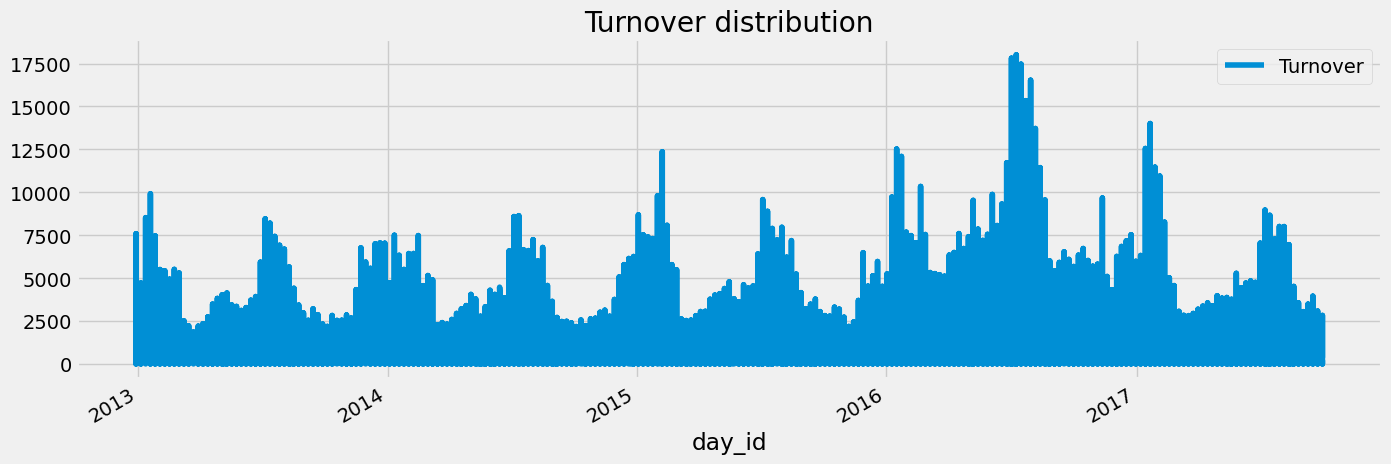

In [16]:
ax = train[['turnover']].plot(figsize=(15, 5))
plt.legend(['Turnover'])
ax.set_title('Turnover distribution')
plt.show()

<Axes: title={'center': 'Outliers'}, xlabel='day_id'>

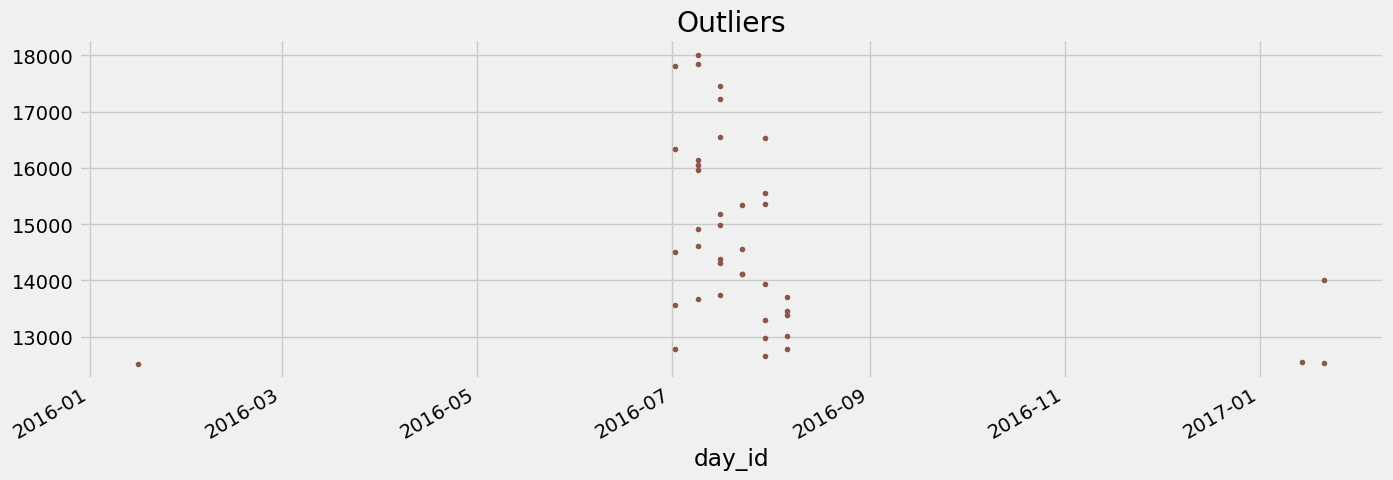

In [17]:
# check for more outliers
train.query('turnover > 12_500')['turnover'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

These outliers may not be due to errors

## **a. Which department made the highest turnover in 2016?**

In [18]:
train_2016 = train[train.index.year == 2016]
turnover_per_dept = train_2016.groupby('dpt_num_department')['turnover'].sum()

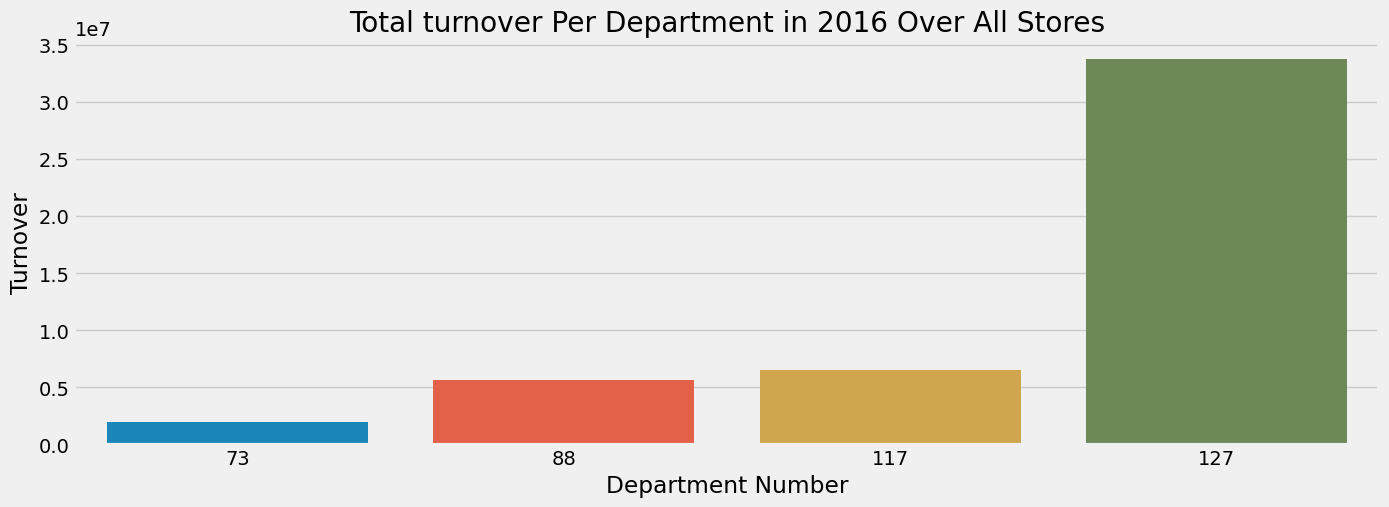

In [19]:
plt.figure(figsize=(15, 5))
sns.barplot(x=turnover_per_dept.index, y=turnover_per_dept.values)
plt.xlabel('Department Number')
plt.ylabel('Turnover')
plt.title('Total turnover Per Department in 2016 Over All Stores')
plt.show()


In [20]:
highest_turnover_dept = turnover_per_dept.idxmax()

equals_line = "=" * 50  
print("".join([equals_line, "Answer", equals_line]))
print(f"The department with the highest turnover in 2016 is the department {highest_turnover_dept}")
print("".join([equals_line, "Answer", equals_line]))

==================================================Answer==================================================
The department with the highest turnover in 2016 is the department 127
==================================================Answer==================================================


## **b. What are the top 5 week numbers (1 to 53) for department 88 in 2015 in terms of turnover over all stores?**

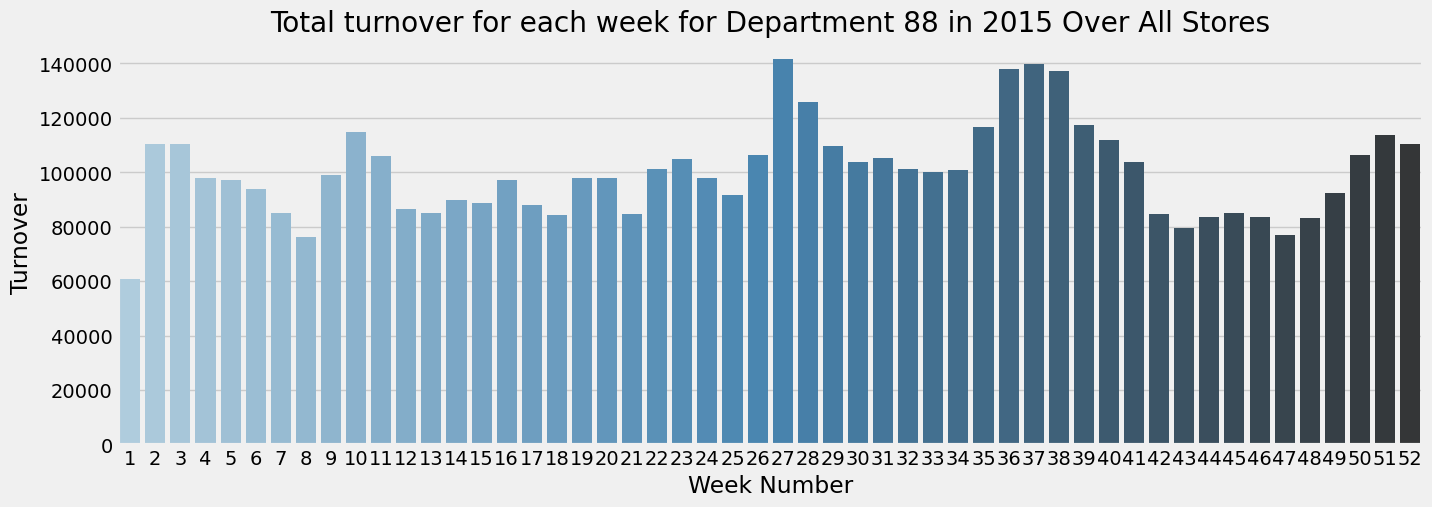

In [21]:
train_2015_dept88 = train[(train.index.year == 2015) & (train['dpt_num_department'] == 88)]

# Total turnover for each week for department 88 in 2015
turnover_per_week_dept88 = train_2015_dept88.groupby(train_2015_dept88.index.isocalendar().week)['turnover'].sum()


plt.figure(figsize=(15, 5))
sns.barplot(x=turnover_per_week_dept88.index, y=turnover_per_week_dept88.values, palette="Blues_d", orient='v')
plt.xlabel('Week Number')
plt.ylabel('Turnover')
plt.title('Total turnover for each week for Department 88 in 2015 Over All Stores')
plt.show()


In [22]:
# Get the top 5 weeks for department 88
top5_weeks_dept88 = turnover_per_week_dept88.nlargest(5).index.tolist()

print("".join([equals_line, "Answer", equals_line]))
print(f"The top 5 week numbers for department 88 in 2015 in terms of turnover over all stores are {top5_weeks_dept88}")
print("".join([equals_line, "Answer", equals_line]))

==================================================Answer==================================================
The top 5 week numbers for department 88 in 2015 in terms of turnover over all stores are [27, 37, 36, 38, 28]
==================================================Answer==================================================


## **c. What was the top performer store in 2014?**

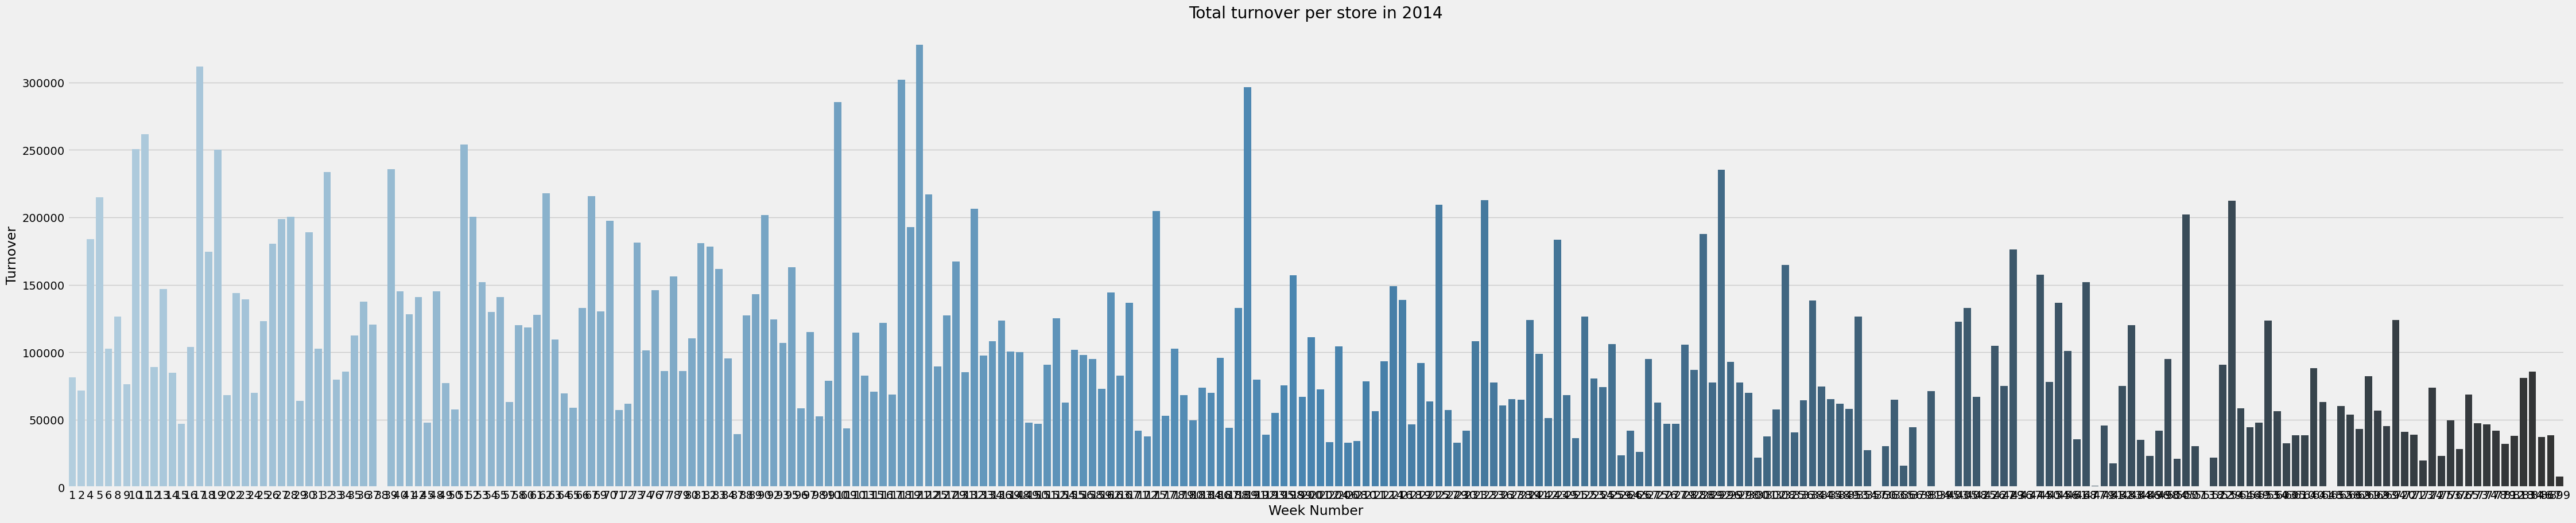

In [23]:
train_2014 = train[train.index.year == 2014]
turnover_per_store = train_2014.groupby('but_num_business_unit')['turnover'].sum()

plt.figure(figsize=(50, 10))
sns.barplot(x=turnover_per_store.index, y=turnover_per_store.values, palette="Blues_d", orient='v')
plt.xlabel('Week Number')
plt.ylabel('Turnover')
plt.title('Total turnover per store in 2014')
plt.show()

In [24]:
top_performer_store = turnover_per_store.idxmax()
print("".join([equals_line, "Answer", equals_line]))
print(f"The top performer store in 2014 was the store {top_performer_store}")
print("".join([equals_line, "Answer", equals_line]))

==================================================Answer==================================================
The top performer store in 2014 was the store 121
==================================================Answer==================================================


## **d. Based on sales can you guess what kind of sport represents departement 73?**

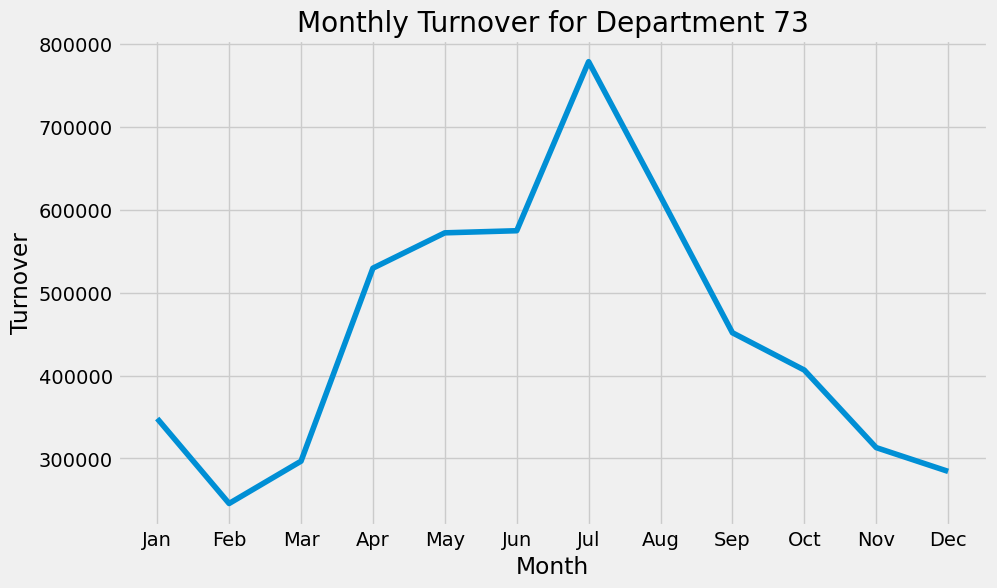

==================================================Answer==================================================
Department 73 is most likely represented by a summer sport like swimming, hiking, or camping.
==================================================Answer==================================================


In [25]:
df_73 = train[train['dpt_num_department'] == 73]

# monthly turnover
monthly_turnover_73 = df_73.groupby('month')['turnover'].sum()

# Plot monthly turnover
plt.figure(figsize=(10, 6))
plt.plot(monthly_turnover_73)
plt.xlabel('Month')
plt.ylabel('Turnover')
plt.title('Monthly Turnover for Department 73')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show();

# Seasonal trends
winter_months = [12, 1, 2]
spring_months = [3, 4, 5]
summer_months = [6, 7, 8]
autumn_months = [9, 10, 11]

winter_turnover_73 = monthly_turnover_73.loc[winter_months].sum()
spring_turnover_73 = monthly_turnover_73.loc[spring_months].sum()
summer_turnover_73 = monthly_turnover_73.loc[summer_months].sum()
autumn_turnover_73 = monthly_turnover_73.loc[autumn_months].sum()

seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
turnovers = [winter_turnover_73, spring_turnover_73, summer_turnover_73, autumn_turnover_73]

# The season with the highest turnover
max_turnover_season = seasons[turnovers.index(max(turnovers))]


print("".join([equals_line, "Answer", equals_line]))
if max_turnover_season == 'Winter':
    print("Department 73 is most likely represented by sport like skiing, snowboarding, or ice skating.")
elif max_turnover_season == 'Spring':
    print("Department 73 is most likely represented by a spring sport like running, cycling, or fishing.")
elif max_turnover_season == 'Summer':
    print("Department 73 is most likely represented by a summer sport like swimming, hiking, or camping.")
elif max_turnover_season == 'Autumn':
    print("Department 73 is most likely represented by an autumn sport like hiking, camping, or hunting.")

print("".join([equals_line, "Answer", equals_line]))

## **e. Based on sales can you guess what kind of sport represents departement 117?**

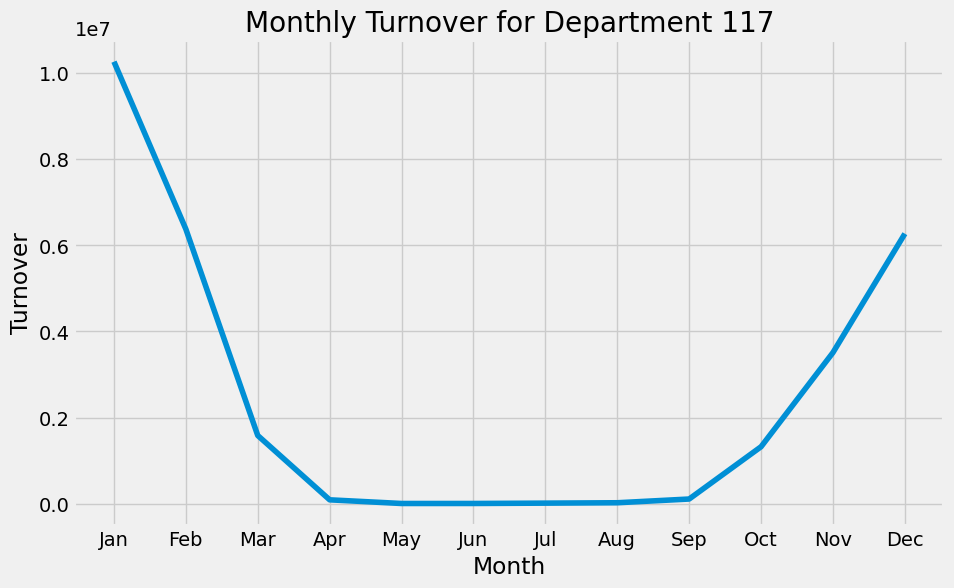

==================================================Answer==================================================
Department 117 is most likely represented by a winter sport like skiing, snowboarding, or ice skating.
==================================================Answer==================================================


In [26]:
df_117 = train[train['dpt_num_department'] == 117]

# Calculate monthly turnover
monthly_turnover_117 = df_117.groupby('month')['turnover'].sum()

# Plot monthly turnover
plt.figure(figsize=(10, 6))
plt.plot(monthly_turnover_117)
plt.xlabel('Month')
plt.ylabel('Turnover')
plt.title('Monthly Turnover for Department 117')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show();

# Seasonal trends
winter_months = [12, 1, 2]
spring_months = [3, 4, 5]
summer_months = [6, 7, 8]
autumn_months = [9, 10, 11]

winter_turnover_117 = monthly_turnover_117.loc[winter_months].sum()
spring_turnover_117 = monthly_turnover_117.loc[spring_months].sum()
summer_turnover_117 = monthly_turnover_117.loc[summer_months].sum()
autumn_turnover_117 = monthly_turnover_117.loc[autumn_months].sum()

seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
turnovers = [winter_turnover_117, spring_turnover_117, summer_turnover_117, autumn_turnover_117]

# The season with the highest turnover
max_turnover_season = seasons[turnovers.index(max(turnovers))]


print("".join([equals_line, "Answer", equals_line]))
if max_turnover_season == 'Winter':
    print("Department 117 is most likely represented by a winter sport like skiing, snowboarding, or ice skating.")
elif max_turnover_season == 'Spring':
    print("Department 117 is most likely represented by a spring sport like running, cycling, or fishing.")
elif max_turnover_season == 'Summer':
    print("Department 117 is most likely represented by a summer sport like swimming, hiking, or camping.")
elif max_turnover_season == 'Autumn':
    print("Department 117 is most likely represented by an autumn sport like hiking, camping, or hunting.")

print("".join([equals_line, "Answer", equals_line]))

## **f. What other insights can you draw from the data? Provide plots and figures if needed.**

- ### Turnover distribution accross the departments

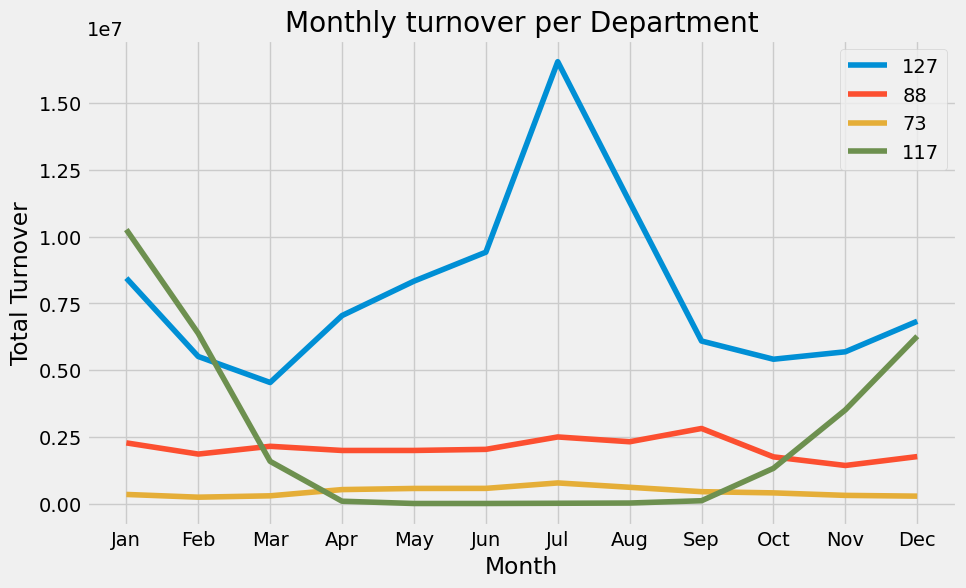

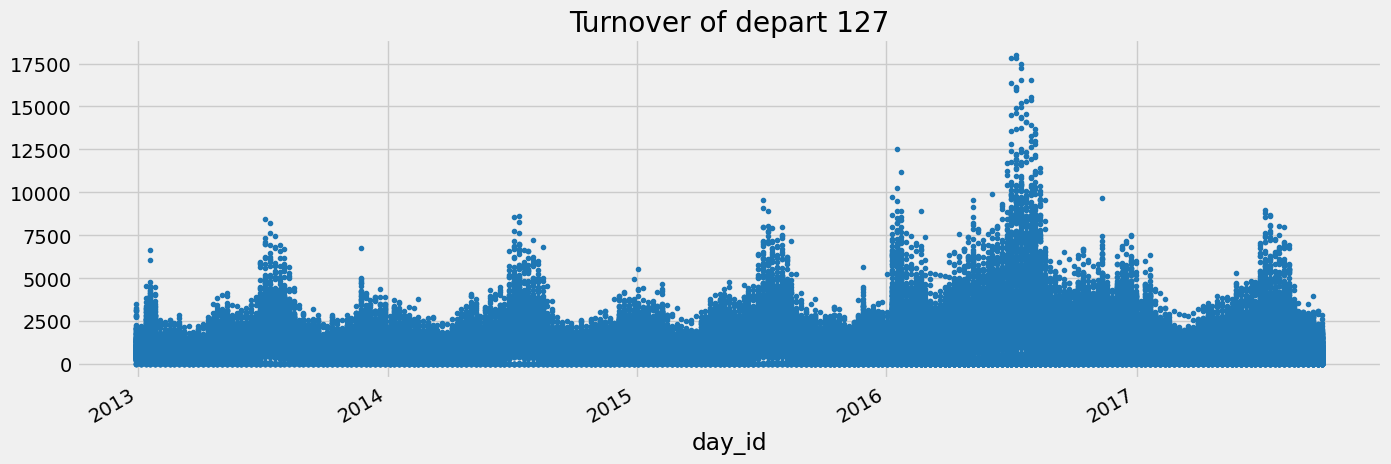

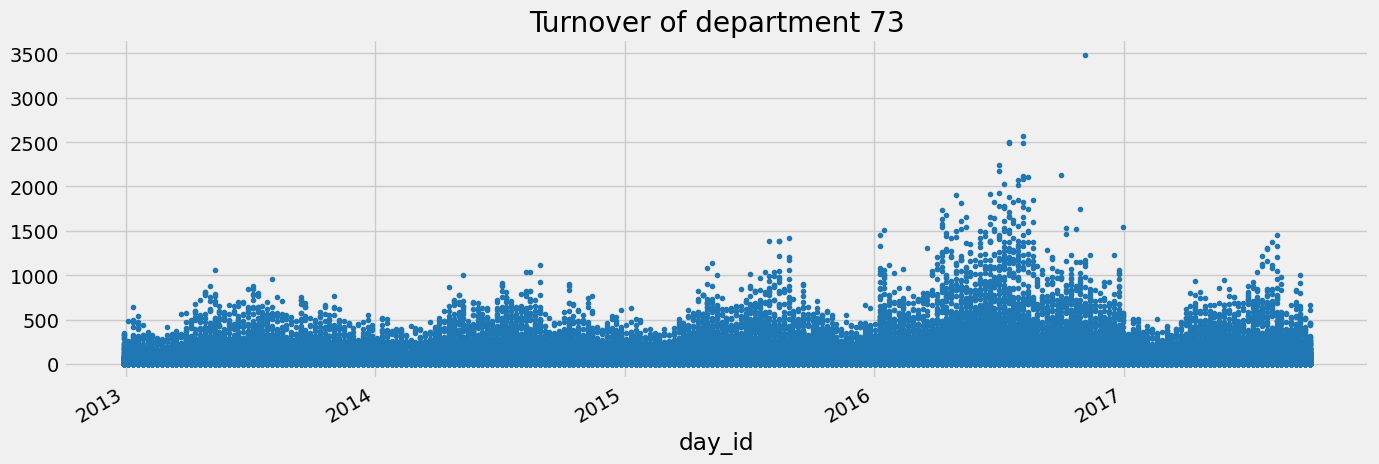

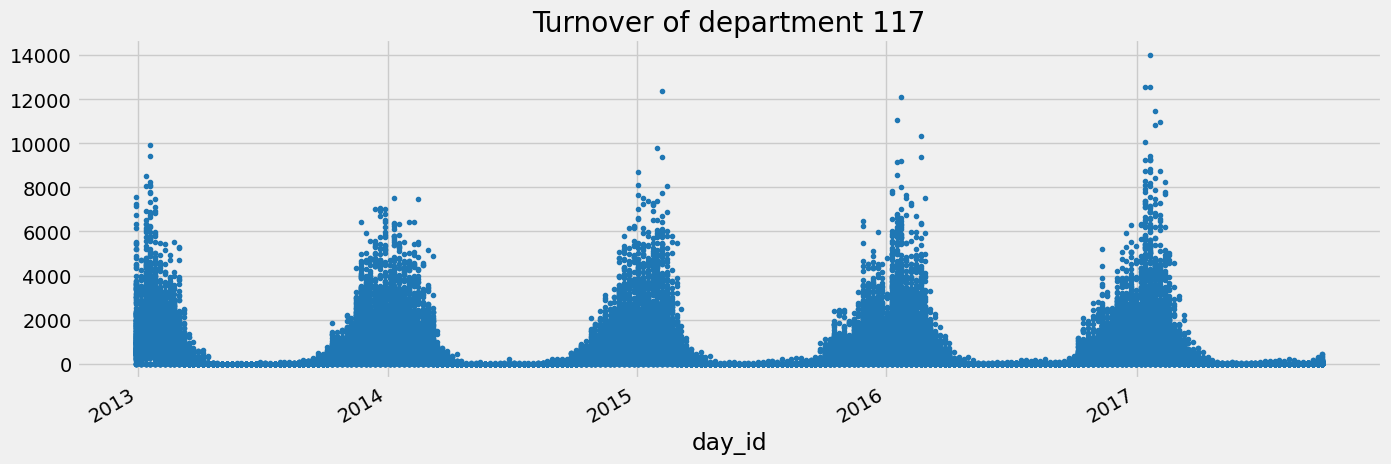

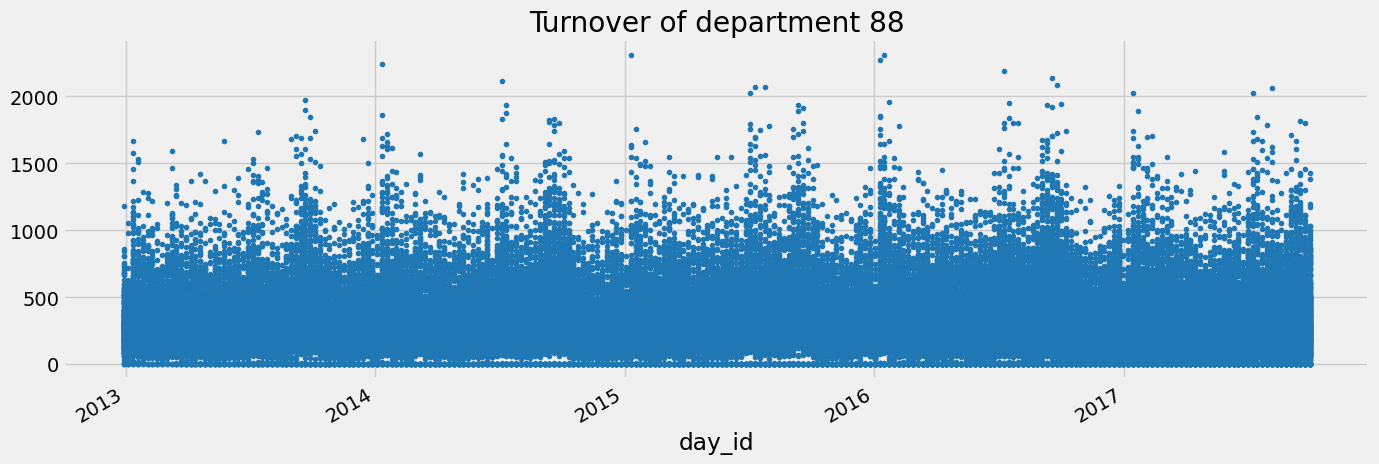

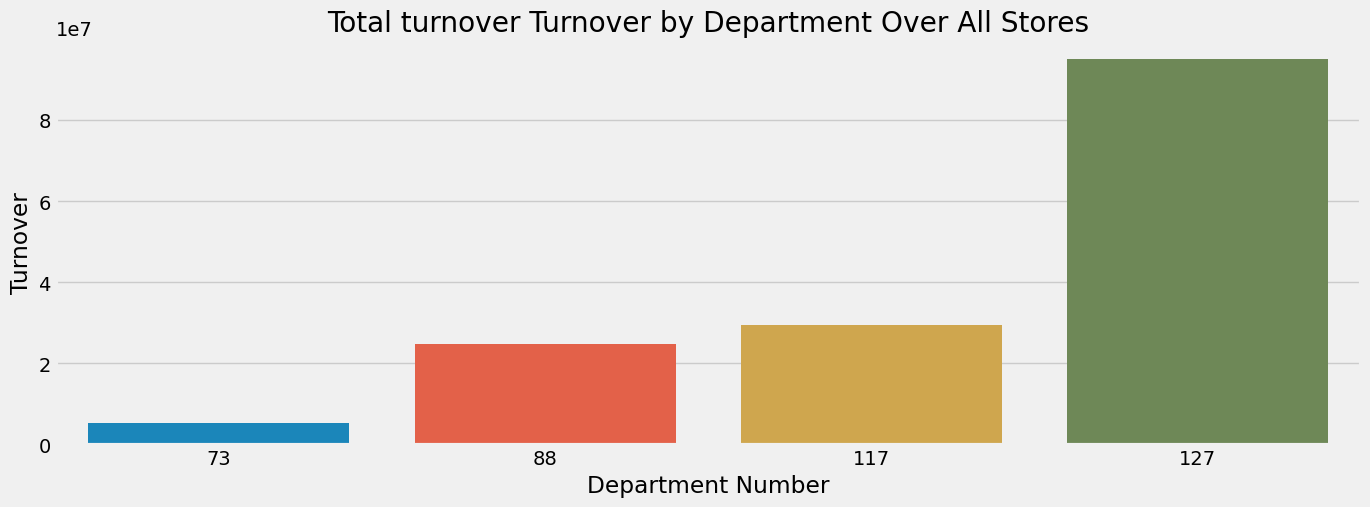

In [27]:
# Get the unique departments
departments = train['dpt_num_department'].unique()
plt.figure(figsize=(10, 6))
# For each department, the total turnover for each month and plot a line chart
for department in departments:
    department_data = train[train['dpt_num_department'] == department]
    monthly_turnover = department_data.groupby('month')['turnover'].sum().reset_index()
    
    plt.plot(monthly_turnover['month'], monthly_turnover['turnover'])
plt.xlabel('Month')
plt.ylabel('Total Turnover')
plt.title(f'Monthly turnover per Department')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(departments)
plt.grid(True)
plt.show()

# ------------------------------------------------------------------------------------

train[train.dpt_num_department==127]['turnover'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Turnover of depart 127')
plt.show()

train[train.dpt_num_department==73]['turnover'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Turnover of department 73')
plt.show()

train[train.dpt_num_department==117]['turnover'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Turnover of department 117')
plt.show()

train[train.dpt_num_department==88]['turnover'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Turnover of department 88')
plt.show()

# -----------------------------------------



department_turnover = train.groupby('dpt_num_department')['turnover'].sum()
plt.figure(figsize=(15, 5))
sns.barplot(x=department_turnover.index, y=department_turnover.values)
plt.xlabel('Department Number')
plt.ylabel('Turnover')
plt.title('Total turnover Turnover by Department Over All Stores')
plt.show()





From the graphs above, it’s clear that department 127 stands out with the highest total turnover among all departments. This suggests that department 127 is performing exceptionally well in terms of generating revenue.

- ### **Departement 127 data analysis**

- ##### Proportion stores in department 127

In [28]:
# 
dept_127 = train[train['dpt_num_department'] == 127]

# number of unique business units in department 127
num_unique_units = dept_127['but_num_business_unit'].nunique()

# total number of unique business units in all departments
total_unique_units = train['but_num_business_unit'].nunique()

#  percentage
percentage = (num_unique_units / total_unique_units) * 100

print(f"Number of unique business units in department 127: {num_unique_units}")
print(f"Percentage of unique business units in department 127: {percentage}%")

Number of unique business units in department 127: 317
Percentage of unique business units in department 127: 98.4472049689441%


This result suggests that department 127 encompasses a vast majority of the unique business units in the dataset. Which is an interesting insight as it might indicate a wide variety of activities or operations are within the department 127.

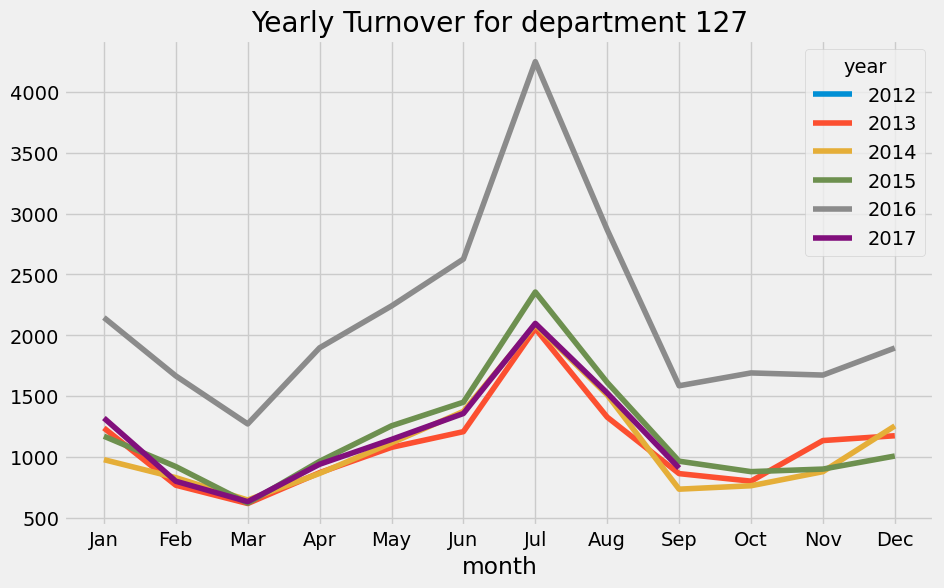

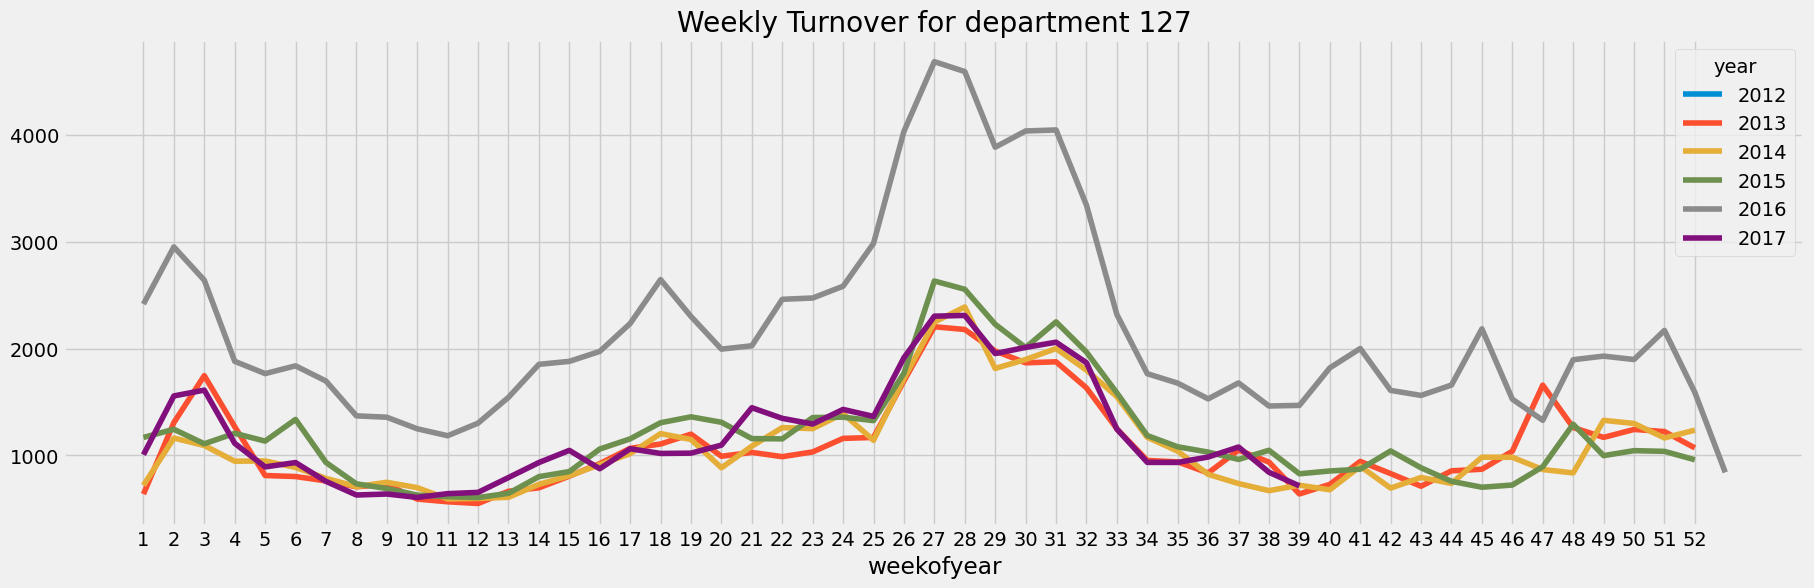

In [29]:
train_depart127 = train[train.dpt_num_department==127]
monthly_turnover = pd.pivot_table(train_depart127, values = "turnover", columns = "year", index = "month")
monthly_turnover.plot(figsize=(10, 6))

plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.title('Yearly Turnover for department 127')
plt.show()


weekly_turnover = pd.pivot_table(train_depart127, values = "turnover", columns = "year", index = "weekofyear")
weekly_turnover.plot(figsize=(20, 6))
plt.xticks(range(1, 53), [str(w) for w  in range(1,53)])
plt.grid(True)
plt.title('Weekly Turnover for department 127')
plt.show()

From the graphs above, we can observe that department 127 reached its peak performance in 2016. Additionally, for department 127, the highest turnover occurs annually in July, particularly during weeks 27 and 28. This pattern suggests that the activities represented by this department may be similar to those of department 73, which are typically summer sports such as swimming, hiking, or camping. 

- #### Top five stores in the department 127 in 2017

In [30]:
train_depart127 = train[(train.dpt_num_department==127) & (train.index.year==2017)]

store_performance = train_depart127.groupby('but_num_business_unit')['turnover'].sum().reset_index()

# Sort the stores by turnover
store_performance = store_performance.sort_values('turnover', ascending=False)

print("Top five stores in the department 127 in 2017")
display(store_performance.head(5))


Top five stores in the department 127 in 2017


,but_num_business_unit,turnover
129,189,164793.444246
93,121,155663.258663
14,17,151254.059598
84,100,140947.070298
91,118,138205.041880


- ### Turnover outlier analysis

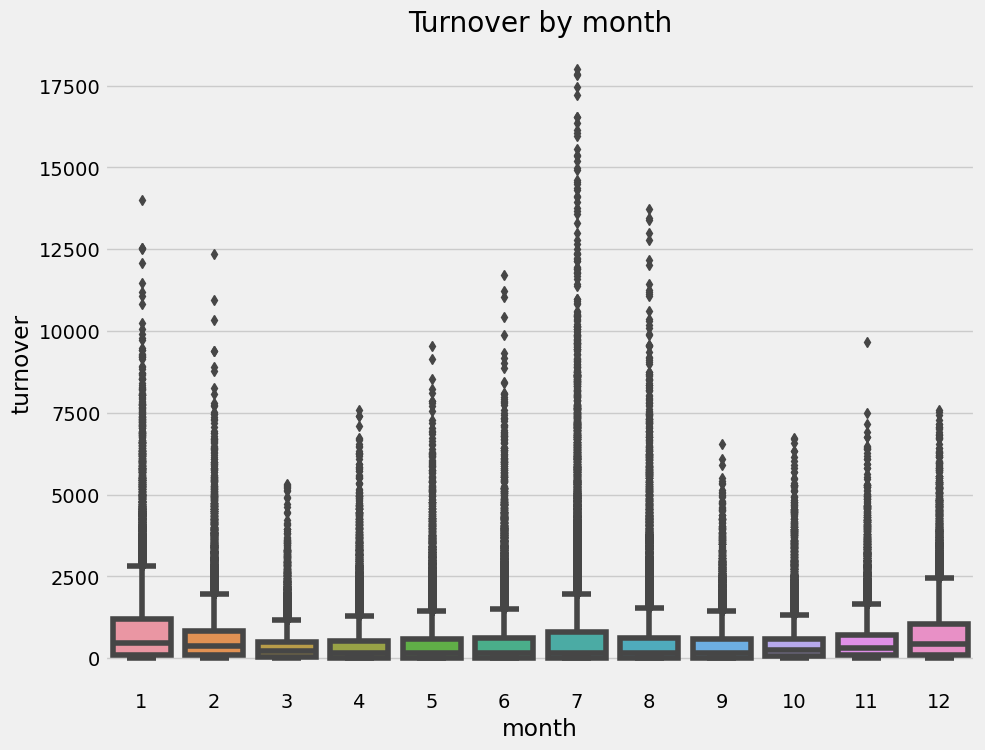

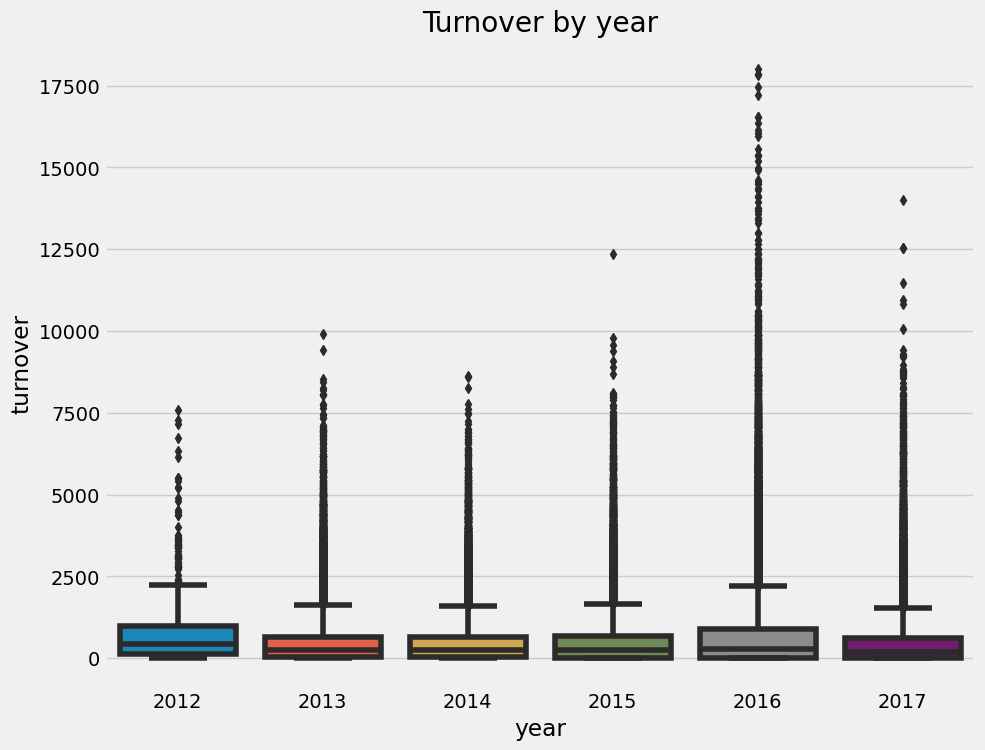

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=train, x='month', y='turnover')
ax.set_title('Turnover by month')
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=train, x='year', y='turnover')
ax.set_title('Turnover by year')
plt.show()

From the first boxplot, It appears that there are some outliers in the turnover for each month.
The second boxplot shows the yearly distribution of turnover, It appears that there are some outliers in the turnover for each year as well.
These outliers could be due to various factors such as seasonal trends, promotional events, or other external factors affecting the turnover. 

## check for missing values

In [32]:
# check for missing values
train.isnull().mean() * 100

but_num_business_unit    0.0
but_postcode             0.0
but_latitude             0.0
but_longitude            0.0
but_region_idr_region    0.0
zod_idr_zone_dgr         0.0
dpt_num_department       0.0
turnover                 0.0
quarter                  0.0
month                    0.0
year                     0.0
weekofyear               0.0
dtype: float64

- ### Turnover distribution across the business unit zones

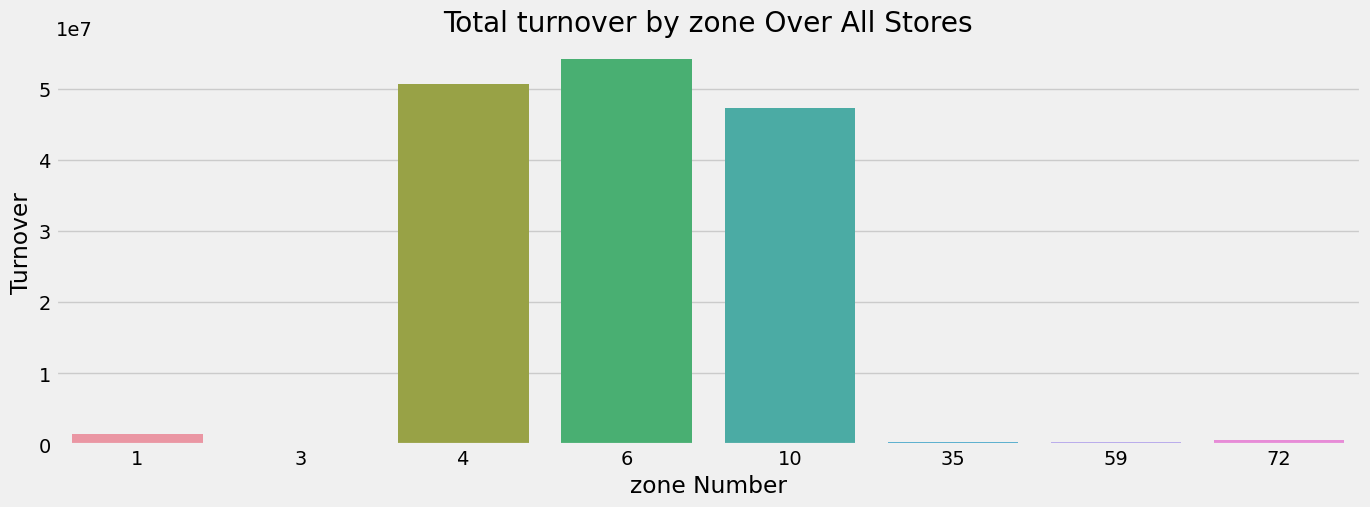

In [33]:
zone_turnover = train.groupby('zod_idr_zone_dgr')['turnover'].sum()
plt.figure(figsize=(15, 5))
sns.barplot(x=zone_turnover.index, y=zone_turnover.values)
plt.xlabel('zone Number')
plt.ylabel('Turnover')
plt.title('Total turnover by zone Over All Stores')
plt.show()

 From the graph, it’s evident that zones 4, 6, and 10 have the highest turnover among all zones. 

In [34]:
# number of stores in each of those zones
store_counts = train.groupby('zod_idr_zone_dgr')['but_num_business_unit'].nunique()

# Get the number of stores in zones 4, 6, and 10
num_stores_zone_4 = store_counts[4]
num_stores_zone_6 = store_counts[6]
num_stores_zone_10 = store_counts[10]

print(f"Number of stores in zone 4: {num_stores_zone_4}")
print(f"Number of stores in zone 6: {num_stores_zone_6}")
print(f"Number of stores in zone 10: {num_stores_zone_10}")


Number of stores in zone 4: 92
Number of stores in zone 6: 95
Number of stores in zone 10: 89
